# Driver Type Classification (Unsupervised)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
sns.set_style("whitegrid", {'axes.grid' : False})

In [36]:
dataset_fcd = pd.read_csv("/kaggle/input/col-data2/dataset_fcd_col_2.csv")
dataset_fcd.head()

,time,id,x,y,angle,type,speed,pos,lane,slope,...,NOx,PMx,fuel,electricity,noise,route,waiting,collision_type,collision_occurred,InvolvedParties
0,0.0,myflow.0,4.8,-194.90,0.0,normal,0.00,5.10,-E7_0,0.0,...,1.20,0.07,837.22,0.0,55.94,rd1#3,0.0,No collision,0,Not involved
1,0.1,myflow.0,4.8,-194.90,0.0,normal,0.01,5.10,-E7_0,0.0,...,1.20,0.07,836.79,0.0,56.60,rd1#3,0.1,No collision,0,Not involved
2,0.2,myflow.0,4.8,-194.89,0.0,normal,0.04,5.11,-E7_0,0.0,...,1.20,0.07,836.44,0.0,57.17,rd1#3,0.2,No collision,0,Not involved
3,0.3,myflow.0,4.8,-194.89,0.0,normal,0.09,5.11,-E7_0,0.0,...,1.20,0.07,837.16,0.0,58.12,rd1#3,0.3,No collision,0,Not involved
4,0.4,myflow.0,4.8,-194.87,0.0,normal,0.17,5.13,-E7_0,0.0,...,1.21,0.07,841.70,0.0,59.55,rd1#3,0.0,No collision,0,Not involved


In [3]:
dataset_fcd = dataset_fcd.drop(['slope','electricity','route','eclass','noise','CO2','CO','HC','NOx','PMx','waiting','collision_type','lane','InvolvedParties'],axis=1) # removing unnecessary variables

## Dataset for Clustering: Feature Engineering 

In [35]:
aggregations = {
    'time': ['max', 'min'],
    'x': 'mean',
    'y': 'mean',
    'angle': 'mean',
    'speed': 'mean',
    'pos': 'mean',
    'acceleration': 'mean',
    'fuel': 'mean',
    'distance': ['max', 'min'],
    'signals': lambda x: x.mode()[0] if not x.mode().empty else None,
    'collision_occurred': lambda x: 1 if x.any() else 0,
    'type': lambda x: x.mode()[0]
}

mean_df = dataset_fcd.groupby('id').agg(aggregations)
mean_df.columns = ['_'.join(col).strip() for col in mean_df.columns.values]
mean_df['total_time'] = mean_df['time_max'] - mean_df['time_min']
mean_df['distance_covered'] = mean_df['distance_max'] - mean_df['distance_min']

mean_df.drop(columns=['time_max', 'time_min', 'distance_max', 'distance_min'], inplace=True)
mean_df.rename(columns={
    'x_mean': 'avg_x',
    'y_mean': 'avg_y',
    'angle_mean': 'avg_angle',
    'speed_mean': 'avg_speed',
    'pos_mean': 'avg_pos',
    'acceleration_mean': 'avg_acceleration',
    'fuel_mean': 'avg_fuel_consumed',
    'signals_<lambda>': 'max_signals',
    'collision_occurred_<lambda>': 'collision_occurred',
    'type_<lambda>': 'type'}, inplace=True)

mean_df.reset_index(inplace=True)
mean_df.head()

,id,avg_x,avg_y,avg_angle,avg_speed,avg_pos,avg_acceleration,avg_fuel_consumed,max_signals,collision_occurred,type,total_time,distance_covered
0,myflow.0,-31.448441,-49.613669,170.255204,9.413765,49.334700,0.377650,1071.371151,0,0,normal,41.6,188.60
1,myflow.1,-4.773199,0.944108,180.014478,13.259697,55.472593,0.748418,2019.300269,0,0,violator,29.6,210.14
2,myflow.10,52.458362,3.425048,270.000000,8.553719,56.031040,0.268015,959.609229,0,0,speeder,51.8,188.31
3,myflow.100,-45.536858,-44.548005,159.766958,9.784788,61.081347,0.364763,1242.035137,0,0,violator,40.0,188.26
4,myflow.101,-4.768700,18.212455,180.017292,14.212708,63.667437,0.807256,1602.939783,0,0,speeder,27.6,209.01


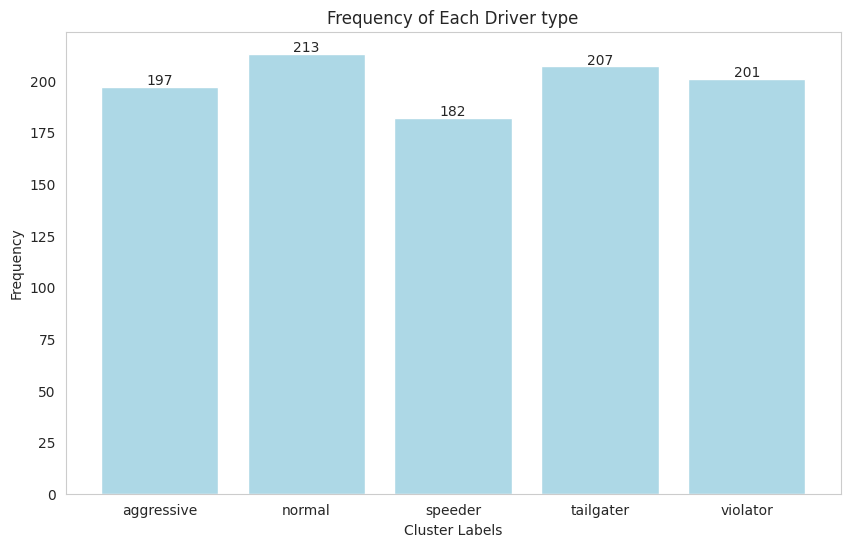

In [5]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+1, y[i], ha = 'center')

values, counts = np.unique(mean_df['type'], return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(values, counts, color='lightblue')
addlabels(values, counts)
plt.xlabel('Cluster Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Each Driver type')
plt.xticks(values)
plt.show()

In [6]:
df = mean_df.drop(['id','type'], axis=1)
X = df.copy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(mean_df['type'])
X.columns

Index(['avg_x', 'avg_y', 'avg_angle', 'avg_speed', 'avg_pos',
       'avg_acceleration', 'avg_fuel_consumed', 'max_signals',
       'collision_occurred', 'total_time', 'distance_covered'],
      dtype='object')

## KMeans Clustering

In [7]:
X_km = X[['total_time','avg_speed','avg_acceleration','distance_covered','max_signals','avg_fuel_consumed','collision_occurred']]
scaler = StandardScaler()
X_zc_km = scaler.fit_transform(X_km)

In [8]:
kmeans = KMeans(n_clusters=5,random_state=42, init='k-means++',n_init='auto')
kmeans.fit(X_zc_km)
inertia = kmeans.inertia_
labels_km = kmeans.labels_
sil_score = silhouette_score(X_zc_km,labels_km)
print(f"n_cluster = 5")
print(f"intertia = {inertia}")
print(f"silhouette score = {sil_score}")

n_cluster = 5
intertia = 2080.1542598580254
silhouette score = 0.4163128888572346


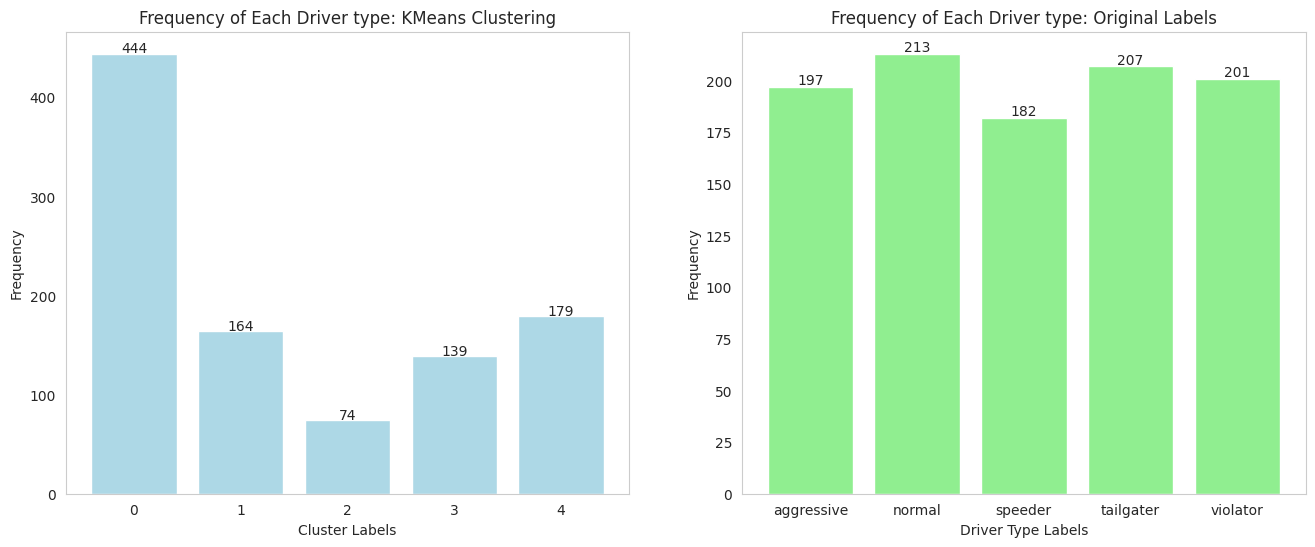

In [9]:
def addlabels(x,y,j):
    for i in range(len(x)):
        ax[j].text(i, y[i]+1, y[i], ha = 'center')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
values_cls, counts_cls = np.unique(labels_km, return_counts=True)
addlabels(values_cls, counts_cls,0)
ax[0].bar(values_cls, counts_cls, color='lightblue')
ax[0].set_xlabel('Cluster Labels')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Frequency of Each Driver type: KMeans Clustering')
ax[0].set_xticks(values_cls)

values_norm, counts_norm = np.unique(mean_df['type'], return_counts=True)
addlabels(values_norm, counts_norm,1)
ax[1].bar(values_norm, counts_norm, color='lightgreen')
ax[1].set_xlabel('Driver Type Labels')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Frequency of Each Driver type: Original Labels')
ax[1].set_xticks(values_norm)

plt.show()

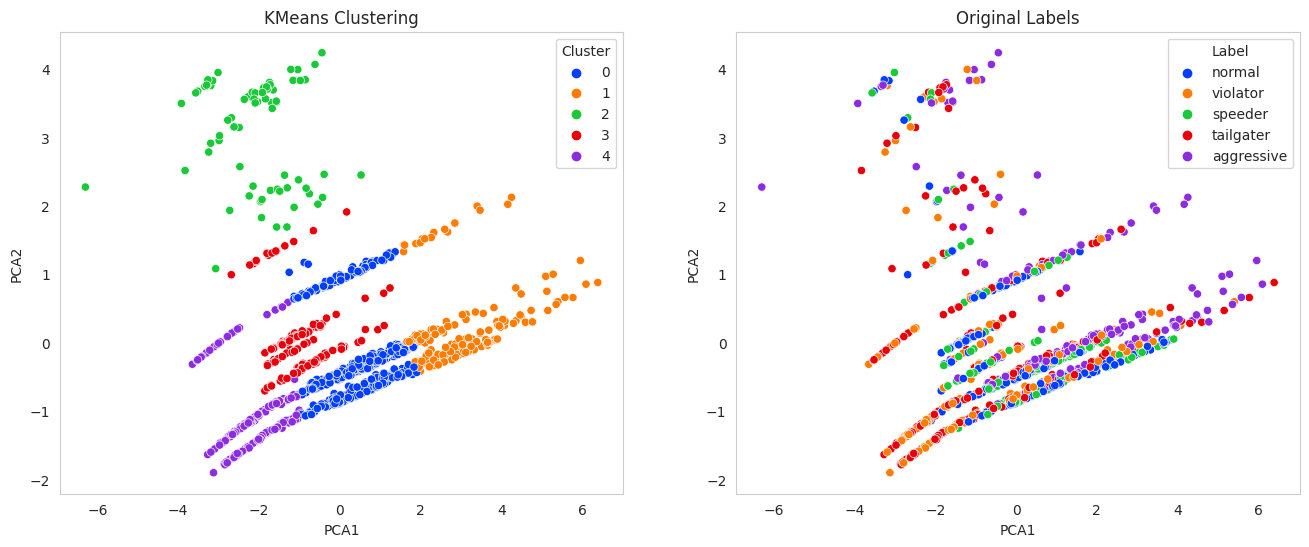

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_zc_km)

df_kmeans = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_kmeans['Cluster'] = labels_km

df_original = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_original['Label'] = mean_df['type']

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='bright', data=df_kmeans, ax=ax[0])
ax[0].set_title('KMeans Clustering')

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', palette='bright', data=df_original, ax=ax[1])
ax[1].set_title('Original Labels')
plt.show()

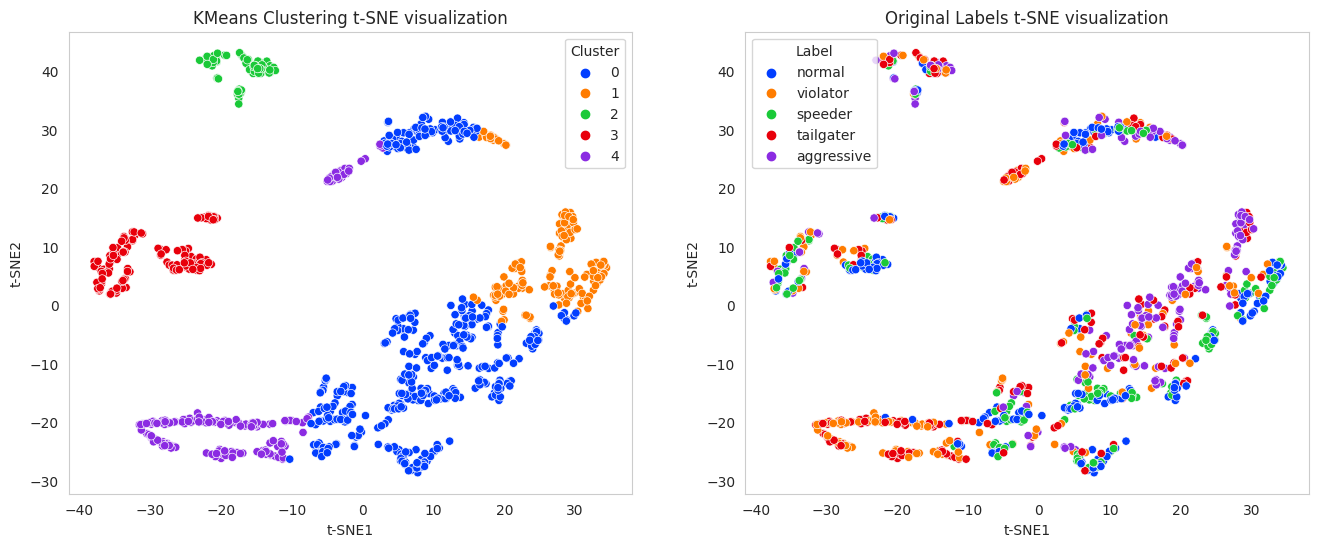

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_zc_km)

df_kmeans_tsne = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
df_kmeans_tsne['Cluster'] = labels_km

df_original_tsne = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
df_original_tsne['Label'] = mean_df['type']

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', palette='bright', data=df_kmeans_tsne, ax=ax[0])
ax[0].set_title('KMeans Clustering t-SNE visualization')

sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Label', palette='bright', data=df_original_tsne, ax=ax[1])
ax[1].set_title('Original Labels t-SNE visualization')
plt.show()

## Hierarchical Clustering

In [12]:
X_hm = X[['total_time','avg_speed','avg_acceleration','distance_covered','max_signals','avg_fuel_consumed','collision_occurred']]
scaler = StandardScaler()
X_zc_hm = scaler.fit_transform(X_hm)

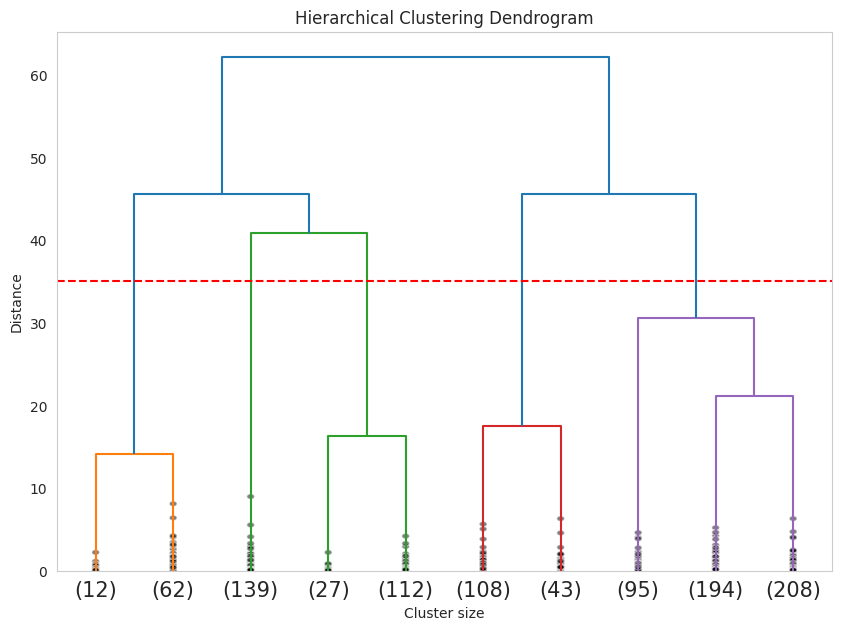

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

Z = linkage(X_zc_hm, method='ward')

plt.figure(figsize=(10, 7))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(Z, truncate_mode='lastp', p=10, leaf_font_size=15.0, show_contracted=True)
plt.axhline(y=35, color='r', linestyle='--')
plt.xlabel("Cluster size")
plt.ylabel("Distance")
plt.show()

In [14]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 35
clusters = fcluster(Z, t=distance_threshold, criterion='distance')
sil_score = silhouette_score(X_zc_hm,clusters)

n_clusters = len(np.unique(clusters))
print(f"Number of clusters: {n_clusters}")
print(f"silhouette score = {sil_score}")

Number of clusters: 5
silhouette score = 0.4081875720978938


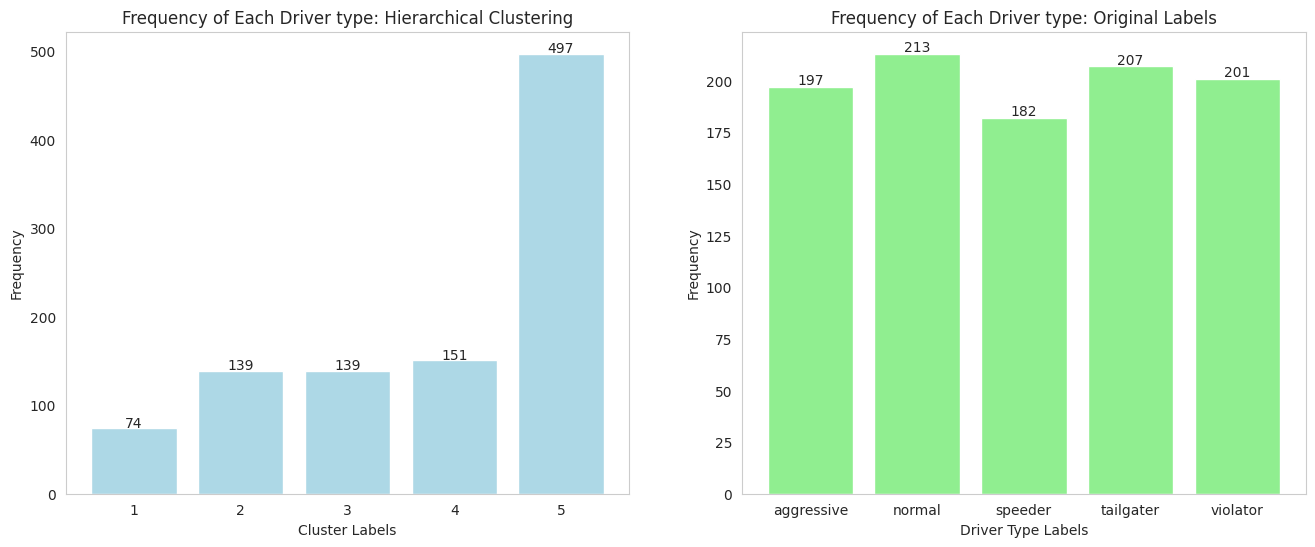

In [15]:
def addlabels(x,y,j):
    for i in range(len(x)):
        ax[j].text(i, y[i]+1, y[i], ha = 'center')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
values_cls, counts_cls = np.unique(clusters, return_counts=True)

ax[0].bar(values_cls, counts_cls, color='lightblue')
for i in range(len(values_cls)):
        ax[0].text(i+1, counts_cls[i]+1, counts_cls[i], ha = 'center')
ax[0].set_xlabel('Cluster Labels')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Frequency of Each Driver type: Hierarchical Clustering')
ax[0].set_xticks(values_cls)

values_norm, counts_norm = np.unique(mean_df['type'], return_counts=True)
addlabels(values_norm, counts_norm,1)
ax[1].bar(values_norm, counts_norm, color='lightgreen')
ax[1].set_xlabel('Driver Type Labels')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Frequency of Each Driver type: Original Labels')
ax[1].set_xticks(values_norm)

plt.show()

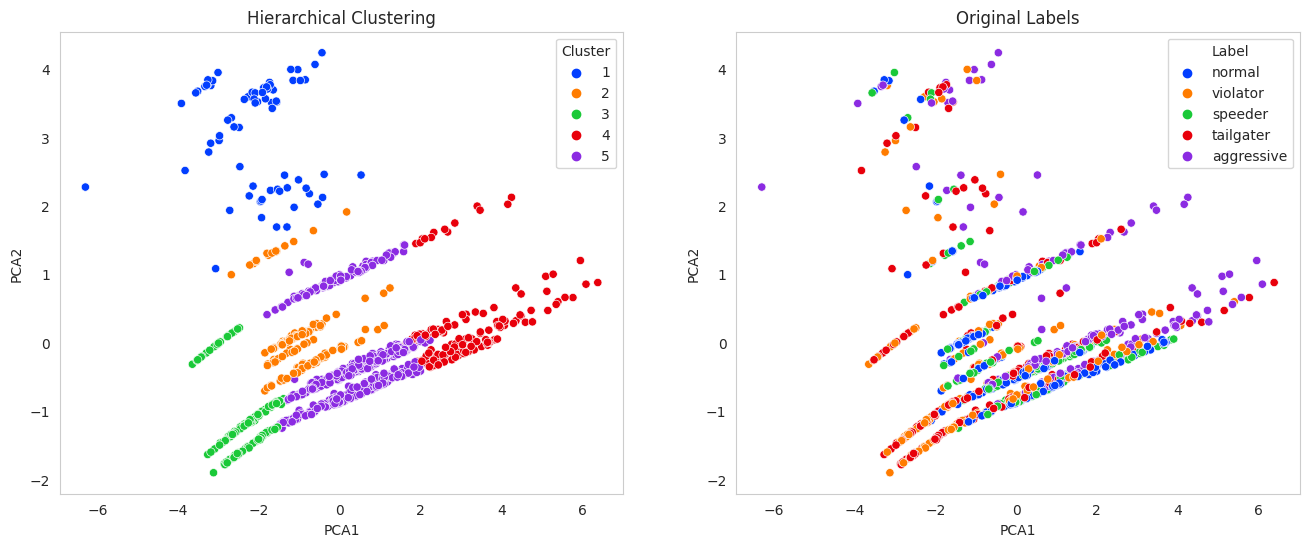

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_zc_hm)

df_hierclus = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_hierclus['Cluster'] = clusters

df_original = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_original['Label'] = mean_df['type']

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='bright', data=df_hierclus, ax=ax[0])
ax[0].set_title('Hierarchical Clustering')

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', palette='bright', data=df_original, ax=ax[1])
ax[1].set_title('Original Labels')
plt.show()

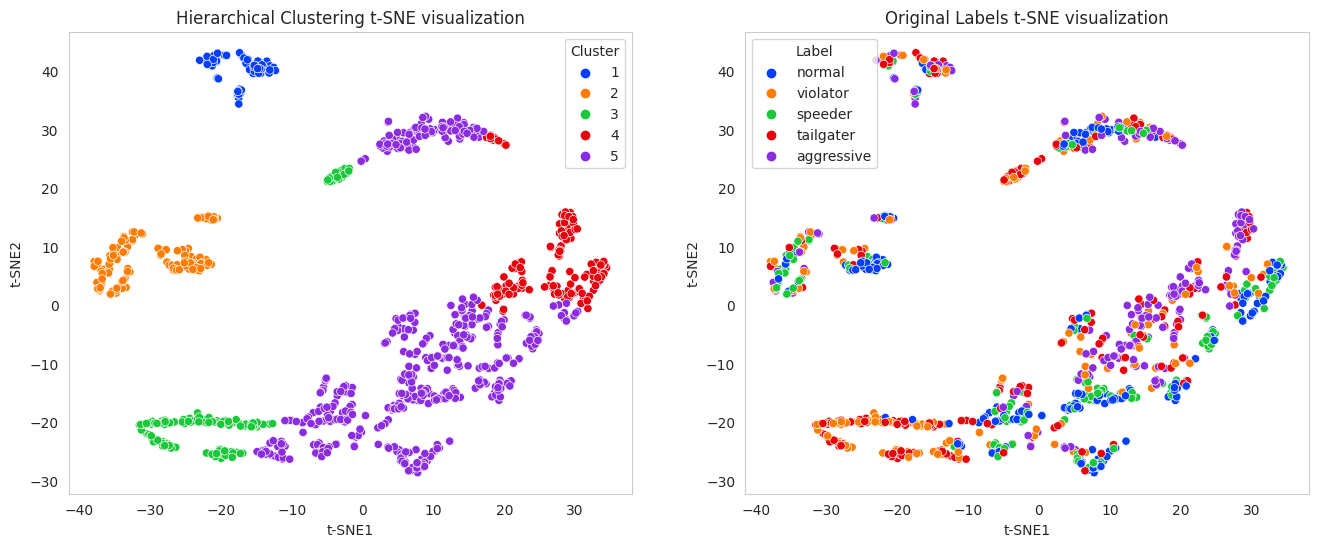

In [17]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_zc_hm)

df_heirclus_tsne = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
df_heirclus_tsne['Cluster'] = clusters

df_original_tsne = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
df_original_tsne['Label'] = mean_df['type']

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', palette='bright', data=df_heirclus_tsne, ax=ax[0])
ax[0].set_title('Hierarchical Clustering t-SNE visualization')

sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Label', palette='bright', data=df_original_tsne, ax=ax[1])
ax[1].set_title('Original Labels t-SNE visualization')
plt.show()

## Autoencoder - KMeans

In [27]:
X_ae = X[['total_time','avg_speed','avg_acceleration','distance_covered','max_signals','avg_fuel_consumed','collision_occurred']]
scaler = StandardScaler()
X_zc_ae = scaler.fit_transform(X_ae)
X_zc_ae.shape[1]

7

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
tf.random.set_seed(42)

input_df = Input(shape=(X_zc_ae.shape[1],))

x = Dense(5, activation='relu')(input_df) #encoding dimension
#x = Dense(10, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(5, activation='relu', kernel_initializer = 'glorot_uniform')(x)

encoded = Dense(3, activation='relu', kernel_initializer = 'glorot_uniform')(x)

x = Dense(5, activation='relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(5, activation='relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense(7, kernel_initializer = 'glorot_uniform')(x)

autoencoder = Model(input_df, decoded)

encoder = Model(input_df, encoded) #using encoder for clustering after training autoencoder

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_6 (Dense)             (None, 5)                 40        
                                                                 
 dense_7 (Dense)             (None, 5)                 30        
                                                                 
 dense_8 (Dense)             (None, 3)                 18        
                                                                 
 dense_9 (Dense)             (None, 5)                 20        
                                                                 
 dense_10 (Dense)            (None, 5)                 30        
                                                                 
 dense_11 (Dense)            (None, 7)                 42  

In [29]:
ae = autoencoder.fit(X_zc_ae,X_zc_ae, batch_size = 5, epochs = 100,  verbose =0, shuffle=True)
print("Loss: ",ae.history['loss'][-1])

Loss:  0.17112836241722107


In [30]:
X_encoded = encoder.predict(X_zc_ae)

kmeans = KMeans(n_clusters=5, random_state=42,n_init='auto')
kmeans.fit(X_encoded);

32/32 [==============================] - 0s 1ms/step


In [31]:
cluster_labels = kmeans.labels_
sil_score = silhouette_score(X_encoded,cluster_labels)
inertia = kmeans.inertia_

print(f"intertia = {inertia}")
print(f"silhouette score = {sil_score}")
X_encoded.shape

intertia = 981.2171020507812
silhouette score = 0.5891705751419067


(1000, 3)

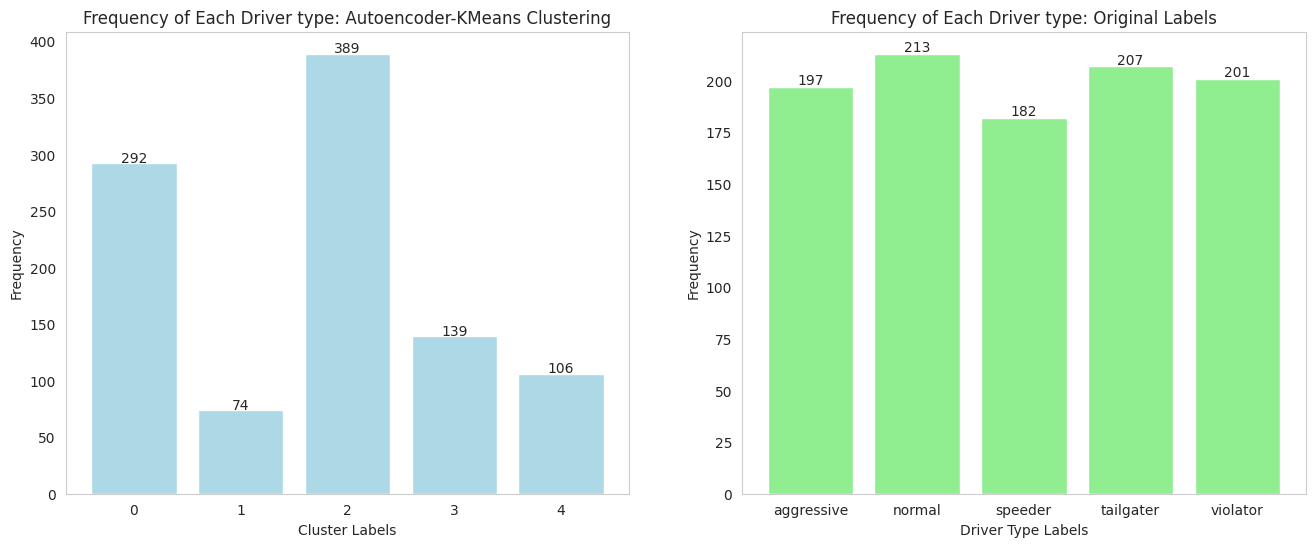

In [32]:
def addlabels(x,y,j):
    for i in range(len(x)):
        ax[j].text(i, y[i]+1, y[i], ha = 'center')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
values_cls, counts_cls = np.unique(cluster_labels, return_counts=True)
addlabels(values_cls, counts_cls,0)
ax[0].bar(values_cls, counts_cls, color='lightblue')
ax[0].set_xlabel('Cluster Labels')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Frequency of Each Driver type: Autoencoder-KMeans Clustering')
ax[0].set_xticks(values_cls)

values_norm, counts_norm = np.unique(mean_df['type'], return_counts=True)
addlabels(values_norm, counts_norm,1)
ax[1].bar(values_norm, counts_norm, color='lightgreen')
ax[1].set_xlabel('Driver Type Labels')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Frequency of Each Driver type: Original Labels')
ax[1].set_xticks(values_norm)

plt.show()

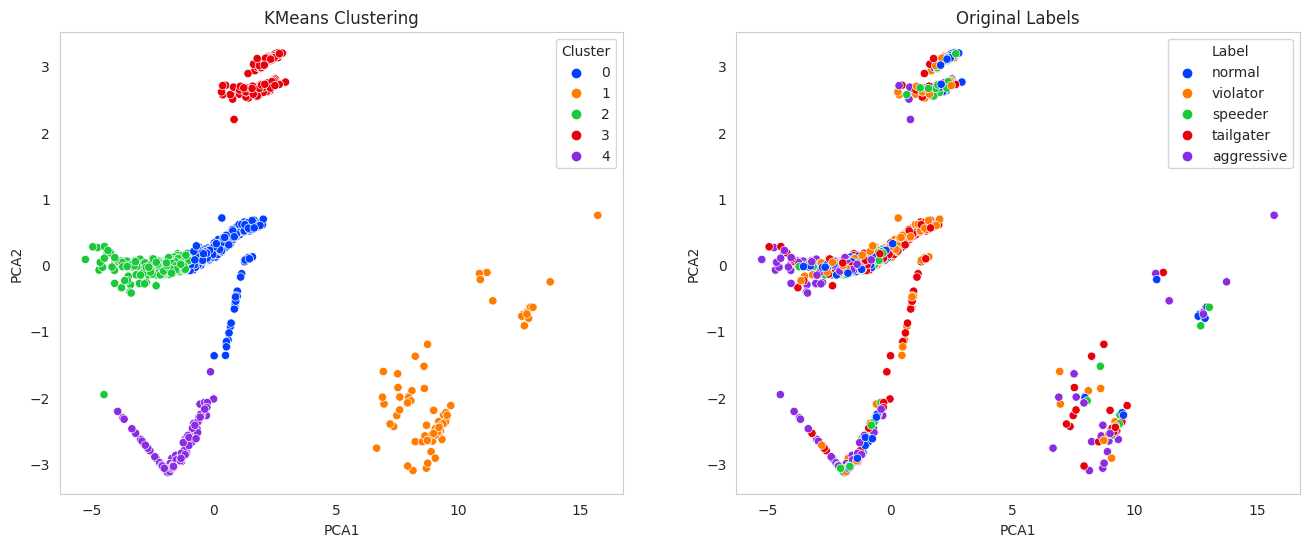

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

df_ae = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_ae['Cluster'] = cluster_labels

df_original = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_original['Label'] = mean_df['type']

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='bright', data=df_ae, ax=ax[0])
ax[0].set_title('KMeans Clustering')

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', palette='bright', data=df_original, ax=ax[1])
ax[1].set_title('Original Labels')
plt.show()

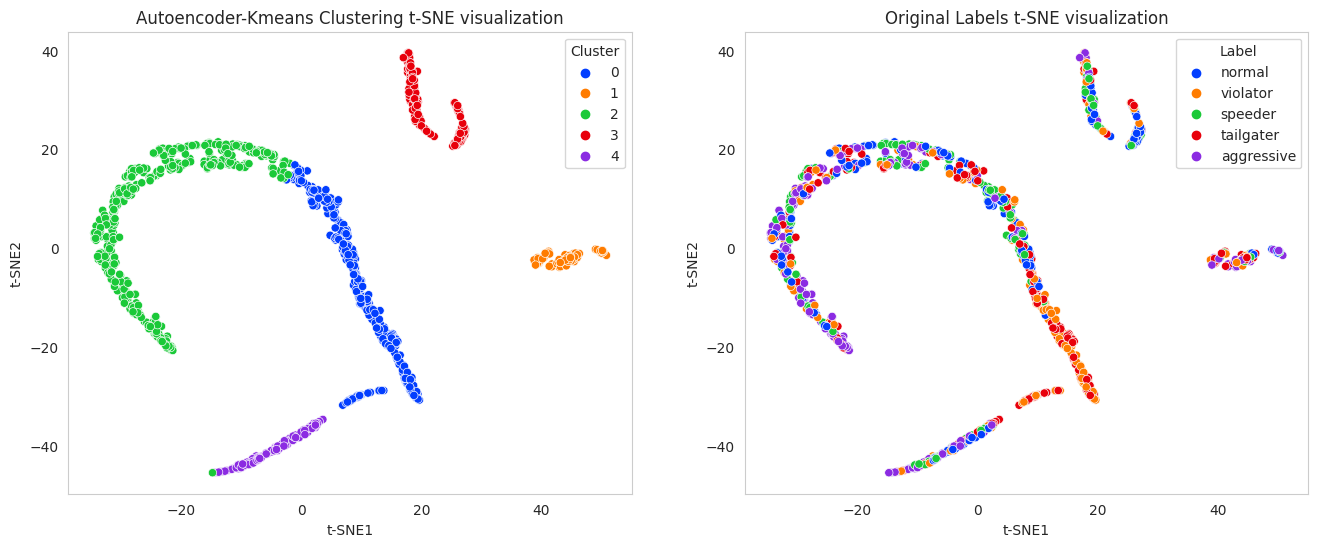

In [34]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

df_ae_tsne = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
df_ae_tsne['Cluster'] = cluster_labels

df_original_tsne = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
df_original_tsne['Label'] = mean_df['type']

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', palette='bright', data=df_ae_tsne, ax=ax[0])
ax[0].set_title('Autoencoder-Kmeans Clustering t-SNE visualization')

sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Label', palette='bright', data=df_original_tsne, ax=ax[1])
ax[1].set_title('Original Labels t-SNE visualization')
plt.show()